# 1. Linear Regression on Fish Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext version_information

In [3]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


### a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [4]:
intercept_column = np.ones((Xt.shape[0], 1))
Xt_with_intercept = np.concatenate((intercept_column, Xt), axis=1)

# w = (X^TX)^-1X^Ty
XTX = np.matmul(Xt_with_intercept.T, Xt_with_intercept)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, Xt_with_intercept.T)
w = np.matmul(XTXIXT, yt)
w

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

### b) Repeat a) but this time with LinearRegression from sklearn.linear_model

In [5]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression(fit_intercept=False) # We have an extended X
model_skl.fit(Xt_with_intercept,yt)
model_skl.coef_

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

### c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) p(y|x) is given by the density of a Gaussian with constant variance phi². Estimate phi² using the variance of the residuals. Use the variance estimation with 1/N.

In [6]:
intercept_column = np.ones((Xte.shape[0], 1))
Xte_with_intercept = np.concatenate((intercept_column, Xte), axis=1)

# Calculate predicted values on the test set
y_pred = np.matmul(Xte_with_intercept, w)
# Calculate residuals
residuals = yte - y_pred
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals**2))
print(rmse)
# Estimate the variance of residuals
variance_estimation = np.var(residuals, ddof=1) # ddof=1 for unbiased estimation
print(variance_estimation)
# Calculate NLL using Gaussian density
nll = 0.5 * (np.log(2 * np.pi * variance_estimation) + np.mean(residuals**2) / variance_estimation)
print(nll)

8.58812638673423
74.97990163183476
3.5693864836483313


### d) For the testset: plot the predicted mean number of fish caught (µ) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of y for a given x. Why is a Gaussian not ideal for that kind of data?

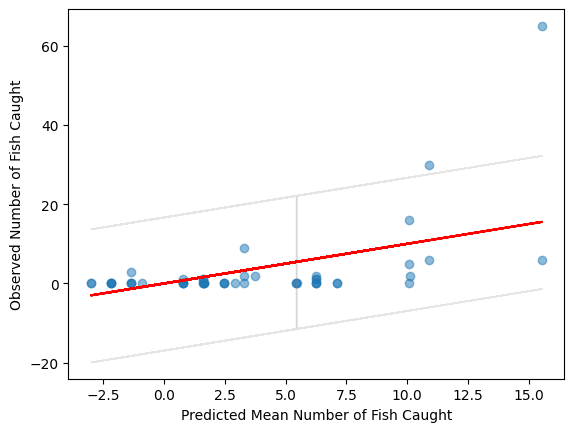

In [7]:
# Calculate standard deviation of residuals
residual_std = np.std(residuals)
# 2.5%
lower_percentile = y_pred - 1.96 * residual_std
# 97.5%
upper_percentile = y_pred + 1.96 * residual_std

plt.scatter(y_pred, yte, alpha=0.5)
plt.plot(y_pred, y_pred, color='red', label='Ideal Prediction Line (y=x)')
plt.fill_between(y_pred, lower_percentile, upper_percentile, color='gray', alpha=0.2, label='95% Prediction Interval')
plt.xlabel('Predicted Mean Number of Fish Caught')
plt.ylabel('Observed Number of Fish Caught')
plt.show()

Diskrete Daten, viele niedrige und wenige sehr hohe Beobachtungen sowie viele Beobachtungen von 0 Fischen.

### e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal. Now use a Poissonian as CPD. [...] Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

In [8]:
from scipy.special import factorial

# Nll for poissson as CPD
def poisson_nll(y_data,x_data,Beta):
    mu=np.exp(np.matmul(x_data,Beta))
    y_int=np.asarray(y_data,dtype=int) # Convert to int array to avoid infinite values in factorial, factorial only work with integers.
    NLL= -mu+ y_data*np.log(mu)-np.log(factorial(y_int)) 
    return np.mean(NLL)

# Test the model
beta=np.ones(5)
nll_test = poisson_nll(yt, Xt_with_intercept,beta) 
print("NLL on the training data:", nll_test)

NLL on the training data: -1507.9856602262082


In [9]:
# Function to calculate the gradient of Poisson NLL
def poisson_gradient(X, y, beta):
    mu = np.exp(np.dot(X, beta))
    gradient = np.dot(X.T, mu - y)
    return gradient

# Function for gradient descent with NLL calculation
def gradient_descent_with_nll(X, y, beta, learning_rate, epochs):
    nll_values = []

    for epoch in range(epochs):
        # Calculate NLL and store it
        nll = poisson_nll(y, X, beta)
        nll_values.append(nll)

        gradient = poisson_gradient(X, y, beta)
        beta = beta - learning_rate * gradient
    return beta, nll_values

# Run gradient descent
beta = np.ones(5)
learning_rate = 0.0001
epochs = 50000
beta_hat, nll_values = gradient_descent_with_nll(Xt_with_intercept, yt, beta, learning_rate, epochs)
print("Estimated beta:", beta_hat)

Estimated beta: [-3.19850436  1.64276453  0.76307097  1.02597981 -1.60144577]


Text(0.5, 0, 'epochs')

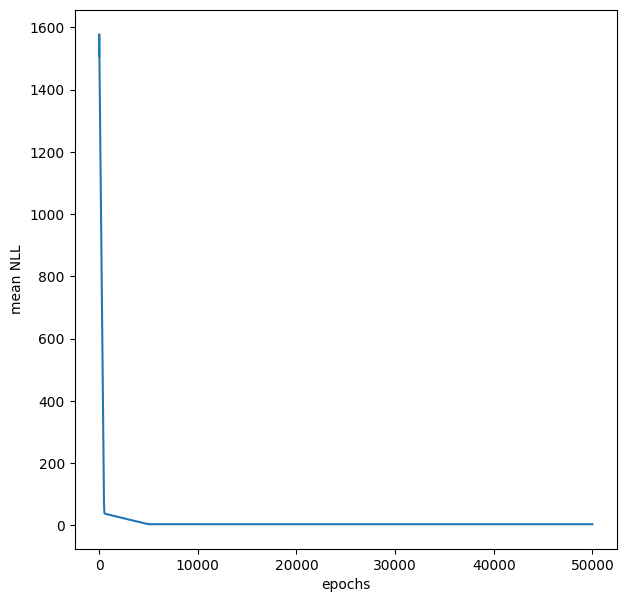

In [10]:
# Visualisierung der NLL
f, ax = plt.subplots(figsize=(7,7))
neg_history= np.asarray(nll_values)*-1 # To have positive values for the NLL
plt.plot(neg_history)
plt.ylabel ('mean NLL')
plt.xlabel ('epochs')

In [11]:
# Calculate RMSE and NLL on the testset
y_pred = np.exp(Xte_with_intercept @ beta_hat)
RMSE = np.sqrt(np.mean((y_pred - yte)**2))
print("RMSE:", RMSE)

# Comparison with the sklearn model
y_pred_skl = model_skl.predict(Xte_with_intercept)
RMSE_skl = np.sqrt(np.mean((y_pred_skl - yte)**2))
print("RMSE sklearn:", RMSE_skl)

RMSE: 7.186987421579501
RMSE sklearn: 8.588126386734231


### f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

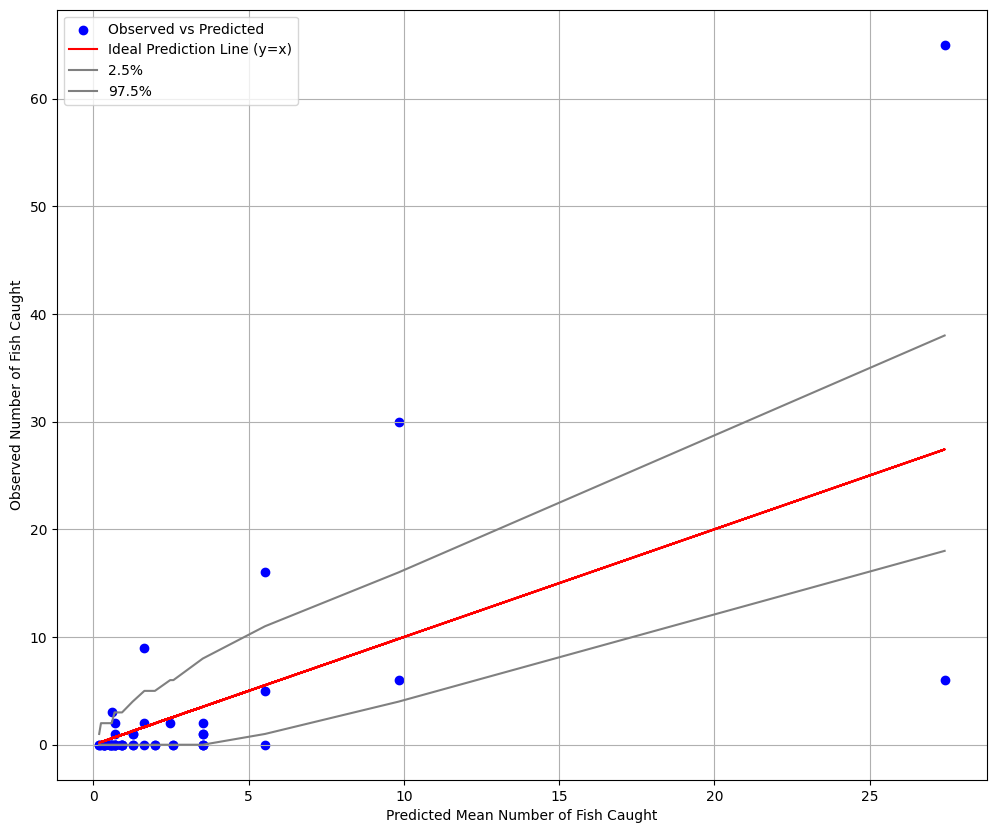

array([ 0.88641953,  0.92381247,  2.47295768,  1.64250051,  0.58874624,
        0.33113604,  1.98144186,  0.92381247,  1.26277407,  3.52292199,
        0.33113604,  0.51959161,  3.52292199,  3.52292199,  0.18624506,
        0.33113604,  0.68148995,  1.26277407,  0.58874624,  9.82834508,
        0.7102381 ,  0.92381247,  0.18624506,  1.26277407,  3.52292199,
        1.26277407,  0.24427672,  2.57727756,  0.58874624,  0.33113604,
        1.64250051,  5.52788124,  0.7102381 ,  0.51959161,  3.52292199,
        3.52292199,  0.7102381 ,  0.58874624,  9.82834508, 27.41938857,
        0.38329907,  0.51959161,  5.52788124,  5.52788124,  0.7102381 ,
        2.57727756, 27.41938857,  0.7102381 ,  1.64250051,  1.98144186])

In [26]:
import scipy.stats as stats

# Calculate the Poisson percentiles for each predicted value
percentile_2_5 = np.sort(stats.poisson(y_pred).ppf(0.025))
percentile_97_5 = np.sort(stats.poisson(y_pred).ppf(0.975))

# Plotting
plt.figure(figsize=(12, 10))
plt.scatter(y_pred, yte, label='Observed vs Predicted', color='blue')
plt.plot(y_pred, y_pred, color='red', label='Ideal Prediction Line (y=x)')
plt.plot(np.sort(y_pred), percentile_2_5, color='gray', label='2.5%')
plt.plot(np.sort(y_pred), percentile_97_5, color='gray', label='97.5%')

plt.xlabel('Predicted Mean Number of Fish Caught')
plt.ylabel('Observed Number of Fish Caught')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
%version_information

Software versions
Python 3.12.0 64bit [MSC v.1935 64 bit (AMD64)]
IPython 8.16.1
OS Windows 11 10.0.22621 SP0
Tue Nov 14 17:06:14 2023 Mitteleuropäische Zeit